In [224]:
import cv2
import sys
import os
import glob
import numpy as np
import copy
import matplotlib.pyplot as plt

## Load Image

In [225]:
def load_image(image_file_path):
  image = cv2.imread(image_file_path)
  
  if image is None:
      sys.exit("Could not read the image.")
  resized_image = cv2.resize(image, (256, 256))
  return resized_image


### Step 1: Convert to Grayscale

In [226]:
def convert_to_gray_scale(rgb_image):
    r, g, b = rgb_image[:,:,0], rgb_image[:,:,1], rgb_image[:,:,2]
    gray_image = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray_image

### Apply filter

In [227]:
def apply_filtering(input_image, kernel):
        if not isinstance(input_image, np.ndarray):
            input_image = np.array(input_image)

        kernel_size = kernel.shape[0]
        pad_size = kernel_size // 2

        padded_image = np.pad(input_image, ((pad_size, pad_size), (pad_size, pad_size)), mode='reflect')

        output_image = np.zeros_like(input_image, dtype=np.float32)

        for i in range(pad_size, padded_image.shape[0] - pad_size):
            for j in range(pad_size, padded_image.shape[1] - pad_size):
                region = padded_image[i-pad_size:i+pad_size+1, j-pad_size:j+pad_size+1]
                output_image[i-pad_size, j-pad_size] = np.sum(region * kernel)

        return output_image

### Step 2: Noise Reduction
(Using a gaussian filter)

In [228]:
def get_gaussian_kernel(kernal_size, sigma=1):
    gaussian_kernal = np.zeros((kernal_size, kernal_size), np.float32)
    size = kernal_size//2

    for x in range(-size, size+1):
        for y in range(-size, size+1):
            a = 1/(2*np.pi*(sigma**2))
            b = np.exp(-(x**2 + y**2)/(2* sigma**2))
            gaussian_kernal[x+size, y+size] = a*b
    return gaussian_kernal/gaussian_kernal.sum()

### Step 3: Gradient Estimation

In [229]:
def gradient_estimate(image, gradient_estimation_filter_type):

  if (gradient_estimation_filter_type=="sobel"):
    Mx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
    My = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)
  elif (gradient_estimation_filter_type=="prewitt"):
    Mx = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]], np.float32)
    My = np.array([[1, 1, 1], [0, 0, 0], [-1, -1, -1]], np.float32)
  else:
    Mx = np.array([[0, 1], [-1, 0]], np.float32)
    My = np.array([[1, 0], [0, -1]], np.float32)

  X = apply_filtering(image, Mx)
  Y = apply_filtering(image, My)

  G = np.hypot(X, Y)
  G = G / G.max() * 255
  theta = np.arctan2(Y, X)
  
  return (G, theta)

### Step 4: Non maximum supression
(Thin out edges)

In [230]:
def non_maxima_suppression(image, gradient_direction):
    rows_count = len(image)
    columns_count = len(image[0])

    output_image = np.zeros((rows_count, columns_count), dtype=np.int32)
    theta = gradient_direction * 180. / np.pi
    theta[theta < 0] += 180

    
    for i in range(1, rows_count-1):
        for j in range(1, columns_count-1):
            next = 255
            previous = 255
            if (0 <= theta[i,j] < 22.5) or (157.5 <= theta[i,j] <= 180):
                next = image[i, j+1]
                previous = image[i, j-1]
            elif (22.5 <= theta[i,j] < 67.5):
                next = image[i+1, j-1]
                previous = image[i-1, j+1]
            elif (67.5 <= theta[i,j] < 112.5):
                next = image[i+1, j]
                previous = image[i-1, j]
            elif (112.5 <= theta[i,j] < 157.5):
                next = image[i-1, j-1]
                previous = image[i+1, j+1]

            if (image[i,j] >= next) and (image[i,j] >= previous):
                output_image[i,j] = image[i,j]
            else:
                output_image[i,j] = 0
    
    return output_image

### Step 5: Apply Thresholds
(Double Threshold)

In [231]:
def double_threshold(image, low_threshold_ratio, high_threshold_ratio):
    
    high_threshold = image.max() * high_threshold_ratio;
    low_threshold = high_threshold * low_threshold_ratio;
    
    rows_count = len(image)
    columns_count = len(image[0])
    output_image = np.zeros((rows_count, columns_count), dtype=np.int32)
    
    weak = np.int32(25)
    strong = np.int32(255)

    strong_i = []
    strong_j = []
    weak_i = [] 
    weak_j = []
    for i in range (len(image)):
      for j in range (len(image[0])):
        if (image[i,j]>=high_threshold):
          strong_i.append(i)
          strong_j.append(j)
        if ((image[i,j] <= high_threshold) & (image[i,j] >= low_threshold)):
          weak_i.append(i)
          weak_j.append(j)
    strong_i = np.array(strong_i)
    strong_j = np.array(strong_j)
    weak_i = np.array(weak_i)
    weak_j = np.array(weak_j)
    
    output_image[strong_i, strong_j] = strong
    output_image[weak_i, weak_j] = weak


    
    return (output_image, weak, strong)

In [232]:
def hysteresis_edge_track(image, weak, strong=255):
    rows_count = len(image)
    columns_count = len(image[0]) 
    for i in range(1, rows_count-1):
        for j in range(1, columns_count-1):
            if (image[i,j] == weak):
                if ((image[i+1, j-1] == strong) or (image[i+1, j] == strong) or (image[i+1, j+1] == strong)
                    or (image[i, j-1] == strong) or (image[i, j+1] == strong)
                    or (image[i-1, j-1] == strong) or (image[i-1, j] == strong) or (image[i-1, j+1] == strong)):
                    image[i, j] = strong
                else:
                    image[i, j] = 0
    return image

In [233]:

def apply_canny_edge_detection(img_path ,kernal_size = 3, low_threshold_ratio = 0.05, high_threshold_ratio = 0.09, gradient_estimation_filter_type = "sobel"):

  # load image
  image = load_image(img_path)
  # print(type(image))
  # print(image.shape)
  # print("Original Image : ")
  # cv2.imshow(image)

  # step 1 : convert image to gray scale
  gray_scaled_image = convert_to_gray_scale(image)
  # print("\nGray Scaled Image : ")
  # cv2.imshow(gray_scaled_image)

  # step 2 : apply gaussian kernal to filter noise
  kernal = get_gaussian_kernel(kernal_size)
  image_without_noise = apply_filtering(gray_scaled_image, kernal)
  # print("\nImage Without Noise : ")
  # cv2.imshow(np.array(image_without_noise))

  # step 3 : gradient estimation
  assert (gradient_estimation_filter_type in ["sobel", "prewitt", "robert"]), "gradient estimation filter type should be [\"prewitt\", \"sobel\", \"robert\"]"
  G, theta = gradient_estimate(image_without_noise, gradient_estimation_filter_type)
  # print("\nImage After Gradient Estimation : ")
  # cv2.imshow(np.array(G))

  # step 4 : non maxima suppression
  image_with_thin_edges = non_maxima_suppression(G, theta)
  # print("\nImage After Non-Maxima Suppression : ")
  # cv2.imshow(np.array(image_with_thin_edges))

  # step 5 : double threshold
  final_image, weak, strong = double_threshold(image_with_thin_edges, low_threshold_ratio, high_threshold_ratio)
  # print("\nImage After Apply Double Threshold : ")
  # cv2.imshow(np.array(final_image))

  # edge tracking with hysteresis
  img = hysteresis_edge_track(final_image, weak, strong=255)
  # print("\nFinalImage")
  # cv2.imshow('Final Image' ,np.array(img))

  return img.astype(np.uint8)

In [234]:
def morphological_closing(img, kernel_size=5):
    # Create a structuring element
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    # Apply morphological closing
    closed = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
    return closed

In [235]:
def fill_holes(binary_image):
    # Invert the binary image
    inverted_binary = cv2.bitwise_not(binary_image)
    # Fill holes using flood fill
    flood_filled = inverted_binary.copy()
    h, w = flood_filled.shape[:2]
    mask = np.zeros((h+2, w+2), np.uint8)
    cv2.floodFill(flood_filled, mask, (0,0), 255)
    # Invert back to the original binary image
    flood_filled_inv = cv2.bitwise_not(flood_filled)
    filled_image = binary_image | flood_filled_inv
    return filled_image

In [175]:
def find_largest_contour(segmented_mask):
    # Convert the grayscale mask to binary
    _, binary_mask = cv2.threshold(segmented_mask, 1, 255, cv2.THRESH_BINARY)

    # Find contours in the binary mask
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Check if any contours were found
    if not contours:
        return None  # Optionally handle the case where no contours are found


    print("Number of contours found: ", len(contours))
    
    # Find the largest contour based on contour area
    # filter small contours
    large_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > 900]
    print("Number of contours after filtering: ", len(large_contours))

    # Create a blank color image the same size as the segmented_mask
    height, width = segmented_mask.shape[:2]
    color_image = np.zeros((height, width, 3), dtype=np.uint8)

    # Draw the largest contour in red on the color image
    
    num_contours_to_draw = min(len(large_contours), 10)
    for i in range(num_contours_to_draw):
        area = cv2.contourArea(large_contours[i])
        print("Area of contour {i}: {area}".format(i=i, area=area))
        cv2.drawContours(color_image, [large_contours[i]], -1, (0, 0, 255), 1)  # Red color and 1 px thickness


    return color_image

In [160]:
def draw_all_contours(segmented_mask):
    # Convert the grayscale mask to binary
    _, binary_mask = cv2.threshold(segmented_mask, 1, 255, cv2.THRESH_BINARY)

    # Find contours in the binary mask
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    print("Number of contours found: ", len(contours))

    # Check if any contours were found
    if not contours:
        return None  # Optionally handle the case where no contours are found

    # filter small contours
    large_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > 50]
    print("Number of contours after filtering: ", len(large_contours))
    # Create a blank color image the same size as the segmented_mask
    height, width = segmented_mask.shape[:2]
    color_image = np.zeros((height, width, 3), dtype=np.uint8)

    # Draw all contours in red on the color image
    for contour in contours:
        cv2.drawContours(color_image, [contour], -1, (0, 0, 255), 1)  # Red color and 1 px thickness

    return color_image

In [183]:
img_path = './data/VOCdevkit/VOC2012/JPEGImages/2007_000123.jpg'
# print(os.path.exists(img_path))
# image = cv2.imread(img_path)
# image = load_image(img_path)
# image = cv2.resize(image, (256, 256))
# gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Canny edge detection
# edges = cv2.Canny(gray_image, 100, 200)
edges = apply_canny_edge_detection(img_path, 3, 0.05, 0.15, "sobel")
print(edges.shape, type(edges))
cv2.imshow("Edges", edges)
cv2.waitKey(0)
# cv2.imshow("Displayed Image", edges)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

# Find largest contour
largest_contour = find_largest_contour(edges)
print(largest_contour.shape, type(largest_contour))
cv2.imshow("Largest Contour Before Edge Closing", largest_contour)
cv2.waitKey(0)

# Morphological closing
closed_edges = morphological_closing(edges, kernel_size=10)
print(closed_edges.shape, type(closed_edges))
cv2.imshow("Filled Edges", closed_edges)
cv2.waitKey(0)

largest_contour = find_largest_contour(closed_edges)
print(largest_contour.shape, type(largest_contour))
cv2.imshow("Largest Contour After Edge Closing", largest_contour)
cv2.waitKey(0)


# Hole filling
filled_edges = fill_holes(closed_edges)
print(filled_edges.shape, type(filled_edges))

# Save or display the result
cv2.imshow("Segmented Mask", filled_edges)
cv2.waitKey(0)
cv2.destroyAllWindows()

(256, 256) <class 'numpy.ndarray'>
Number of contours found:  185
Number of contours after filtering:  0
(256, 256, 3) <class 'numpy.ndarray'>
(256, 256) <class 'numpy.ndarray'>
Number of contours found:  5
Number of contours after filtering:  2
Area of contour 0: 33433.5
Area of contour 1: 1039.0
(256, 256, 3) <class 'numpy.ndarray'>
(256, 256) <class 'numpy.ndarray'>


In [193]:
# # helper for filling in ground mask
# from scipy.ndimage import label
# def fill_all_objects(mask):
#     """
#     Fills the inner area of enclosed boundaries or objects in the binary mask using NumPy.
#     """
#     if mask is None:
#         return None
    
#     # Ensure the mask is binary
#     mask = np.where(mask > 0, 1, 0).astype(np.uint8)
    
#     # Invert the mask to ensure the fill starts from the background
#     inverted_mask = np.logical_not(mask)
    
#     # Label connected components in the inverted mask
#     labeled_array, num_features = label(inverted_mask)
    
#     # Assume the largest connected component in the inverted mask is the background
#     max_label = 0
#     max_size = 0
#     for i in range(1, num_features + 1):
#         size = np.sum(labeled_array == i)
#         if size > max_size:
#             max_size = size
#             max_label = i

#     # Create a filled mask based on the largest background region
#     filled_mask = np.logical_not(labeled_array == max_label).astype(np.uint8) * 255

#     return filled_mask

In [221]:
def compare_masks(predicted_mask, ground_truth_mask):
    """
    Function to compare the predicted mask with the ground truth mask and return IoU, Accuracy, and Dice score.
    """
    if predicted_mask is None or ground_truth_mask is None:
        print("One or both masks are None. Skipping comparison.")
        return None

    if predicted_mask.shape != ground_truth_mask.shape:
        print("Masks shapes do not match. Skipping comparison.")
        return None

    # Calculate intersection and union
    intersection = np.sum(predicted_mask & ground_truth_mask)
    union = np.sum(predicted_mask | ground_truth_mask)

    print(np.sum(intersection), np.sum(union), np.sum(ground_truth_mask))
    print(np.sum(predicted_mask))

    # Calculate metrics
    iou = np.sum(intersection) / np.sum(union) if np.sum(union) != 0 else 0
    accuracy = np.sum(intersection) / np.sum(ground_truth_mask) if np.sum(ground_truth_mask) != 0 else 0
    dice = 2 * np.sum(intersection) / (np.sum(predicted_mask) + np.sum(ground_truth_mask)) if np.sum(predicted_mask) + np.sum(ground_truth_mask) != 0 else 0

    return {'IoU': iou, 'Accuracy': accuracy, 'Dice': dice}


In [100]:
def visualize_comparison(image_name, predicted_mask, ground_truth_mask):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 3, 1)
    plt.title(f"Predicted Mask: {image_name}")
    plt.imshow(predicted_mask, cmap='gray')

    plt.subplot(1, 3, 2)
    plt.title(f"Ground Truth Mask: {image_name}")
    plt.imshow(ground_truth_mask, cmap='gray')

    plt.subplot(1, 3, 3)
    plt.title("Overlay")
    plt.imshow(predicted_mask, cmap='jet', alpha=0.5)
    plt.imshow(ground_truth_mask, cmap='gray', alpha=0.5)

    plt.tight_layout()
    plt.show()

In [125]:
# from scipy.ndimage import label
# def fill_object(mask):
#     """
#     Fills the largest connected component in the binary mask using NumPy.
#     """

#     if mask is None:
#         return None
    
#     # Ensure the mask is binary
#     mask = np.where(mask > 0, 1, 0).astype(np.uint8)
    
#     # Label connected components
#     labeled_array, num_features = label(mask)
    
#     # Identify the largest connected component
#     max_label = 0
#     max_size = 0
#     for i in range(1, num_features + 1):
#         size = np.sum(labeled_array == i)
#         if size > max_size:
#             max_size = size
#             max_label = i

#     # Fill the largest connected component
#     filled_mask = np.where(labeled_array == max_label, 1, 0).astype(np.uint8) * 255
    
#     return filled_mask

In [130]:
# from scipy.ndimage import label
# def fill_all_objects(mask):
#     """
#     Fills the inner area of enclosed boundaries or objects in the binary mask using NumPy.
#     """
#     if mask is None:
#         return None
    
#     # Ensure the mask is binary
#     mask = np.where(mask > 0, 1, 0).astype(np.uint8)
    
#     # Invert the mask to ensure the fill starts from the background
#     inverted_mask = np.logical_not(mask)
    
#     # Label connected components in the inverted mask
#     labeled_array, num_features = label(inverted_mask)
    
#     # Assume the largest connected component in the inverted mask is the background
#     max_label = 0
#     max_size = 0
#     for i in range(1, num_features + 1):
#         size = np.sum(labeled_array == i)
#         if size > max_size:
#             max_size = size
#             max_label = i

#     # Create a filled mask based on the largest background region
#     filled_mask = np.logical_not(labeled_array == max_label).astype(np.uint8) * 255

#     return filled_mask

In [203]:
def flood_fill_segmentation(binary_image):
    inverted_binary = cv2.bitwise_not(binary_image)
    
    flood_filled = inverted_binary.copy()
    h, w = flood_filled.shape[:2]
    
    seed_point = (w // 2, h // 2)  # Using the center of the image as the seed point
    mask = np.zeros((h + 2, w + 2), np.uint8)
    cv2.floodFill(flood_filled, mask, seed_point, 255)
    
    flood_filled_inv = cv2.bitwise_not(flood_filled)
    filled_image = binary_image | flood_filled_inv
    return filled_image

In [204]:
def mask_on(img_path):
    mask_edges = apply_canny_edge_detection(img_path, 5, 0.06, 0.10, "sobel")
    closed_edges = morphological_closing(mask_edges, kernel_size=10)
    mask = flood_fill_segmentation(closed_edges)
    return mask
    

(256, 256) (256, 256)
7594665 1387455
1224510 7757610 1387455
7594665
Image: 2007_000032.jpg, IoU: 0.15784629544408652, Accuracy: 0.882558353243889, Dice: 0.2726550079491256


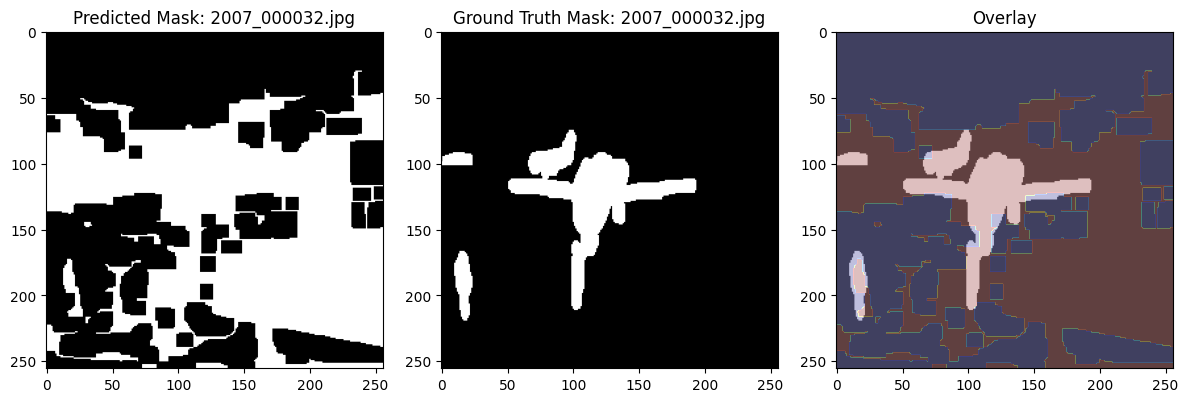

(256, 256) (256, 256)
6011370 3657975
2538270 7131075 3657975
6011370
Image: 2007_000033.jpg, IoU: 0.3559449311639549, Accuracy: 0.6939003136981526, Dice: 0.5250138453018276


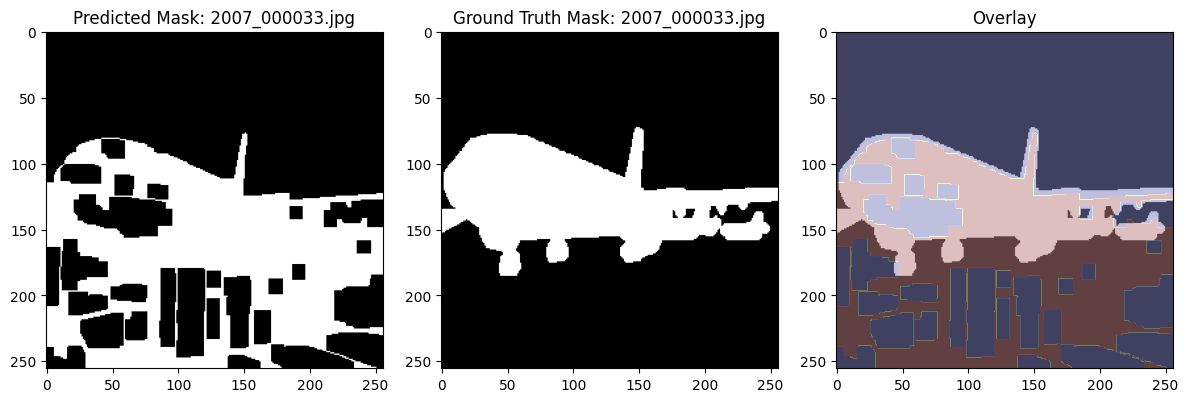

(256, 256) (256, 256)
6402285 2963100
823650 8541735 2963100
6402285
Image: 2007_000039.jpg, IoU: 0.09642654566080544, Accuracy: 0.27796901893287435, Dice: 0.17589239524055872


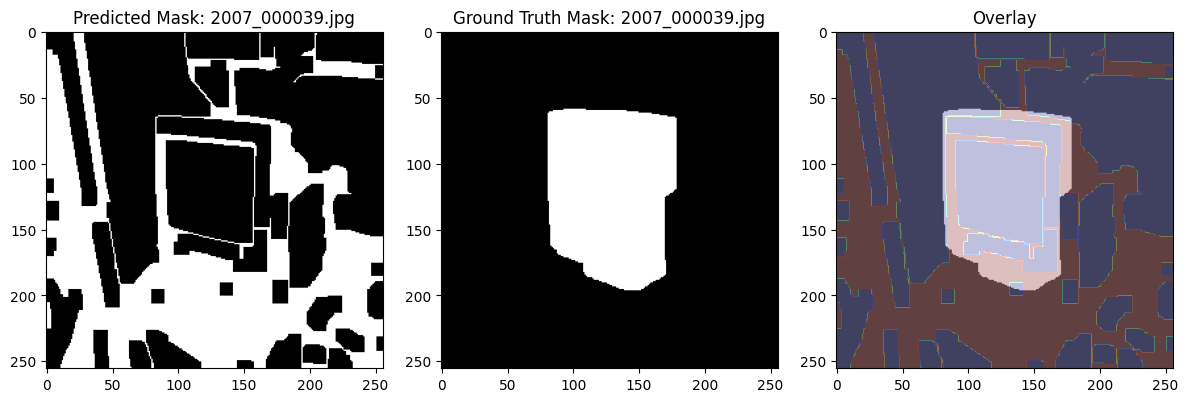

(256, 256) (256, 256)
8034030 10437405
5430480 13040955 10437405
8034030
Image: 2007_000042.jpg, IoU: 0.4164173559375061, Accuracy: 0.5202902445579145, Dice: 0.5879868023247787


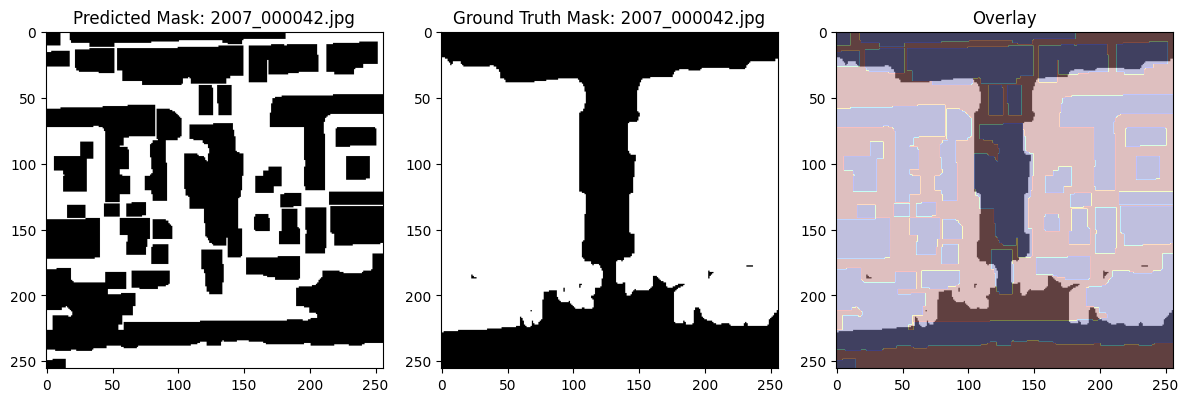

(256, 256) (256, 256)
7941210 1627155
1471350 8097015 1627155
7941210
Image: 2007_000061.jpg, IoU: 0.1817151135325796, Accuracy: 0.9042469832314685, Dice: 0.30754470591370625


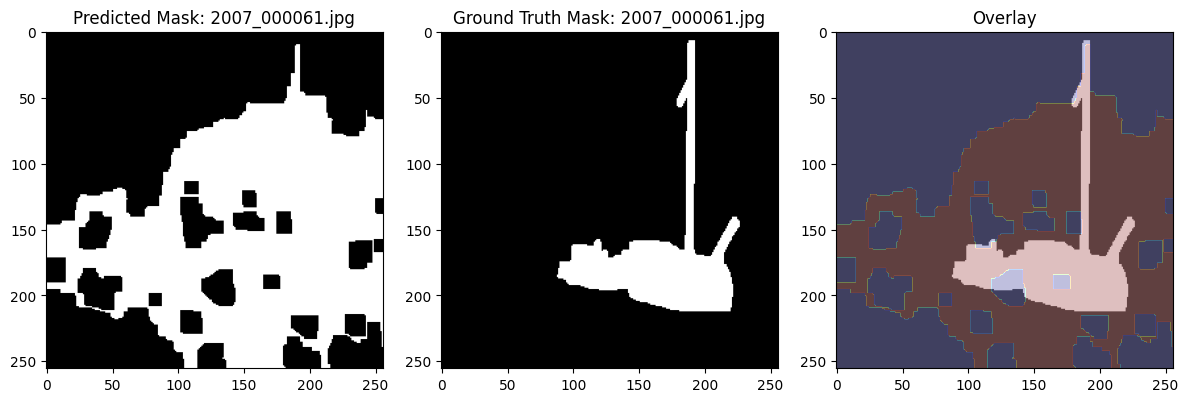

(256, 256) (256, 256)
9029295 10327755
4734585 14622465 10327755
9029295
Image: 2007_000063.jpg, IoU: 0.3237884310203512, Accuracy: 0.45843312510802203, Dice: 0.48918456066394417


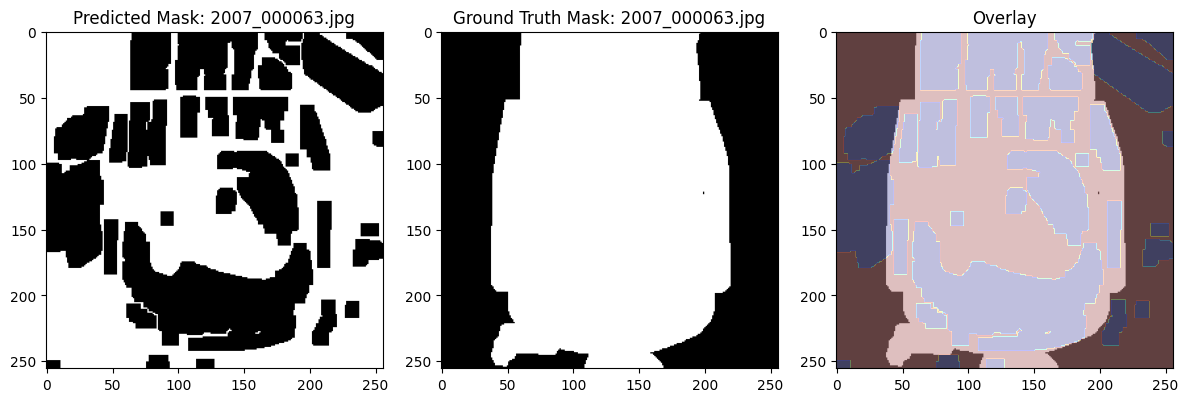

(256, 256) (256, 256)
10171185 1907400
1897965 10180620 1907400
10171185
Image: 2007_000068.jpg, IoU: 0.18642921550946798, Accuracy: 0.9950534759358288, Dice: 0.3142694280828425


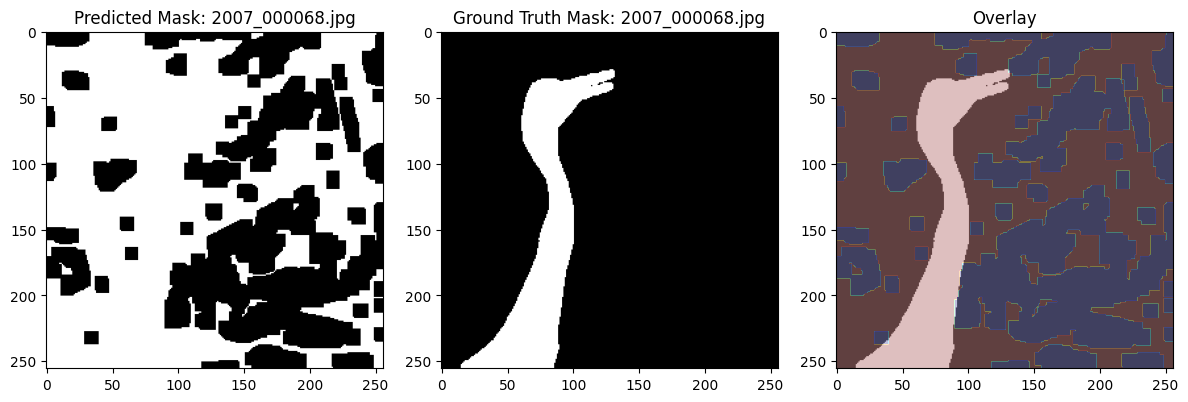

(256, 256) (256, 256)
6562170 8297190
2211105 12648255 8297190
6562170
Image: 2007_000121.jpg, IoU: 0.17481502389064738, Accuracy: 0.26648841354723707, Dice: 0.29760433827567273


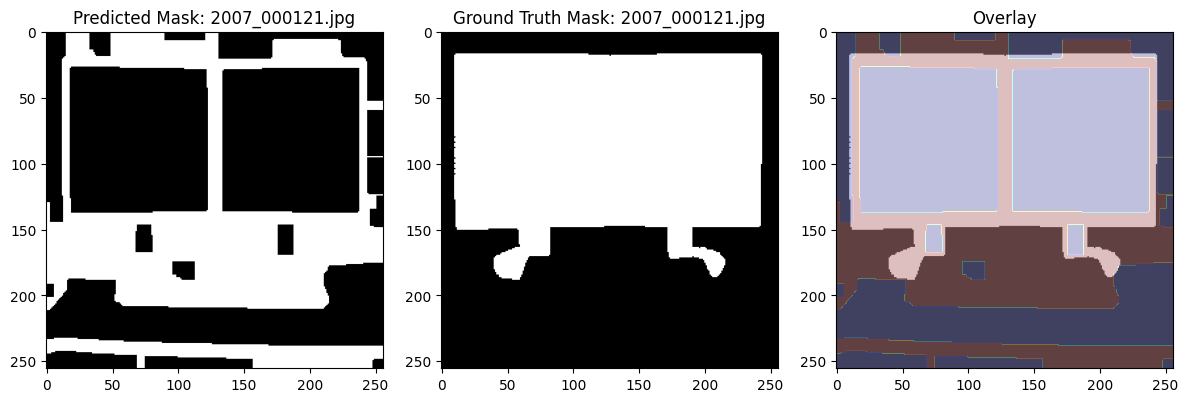

(256, 256) (256, 256)
9450555 7036980
6002955 10484580 7036980
9450555
Image: 2007_000123.jpg, IoU: 0.572550831792976, Accuracy: 0.8530584142629366, Dice: 0.7281810167499265


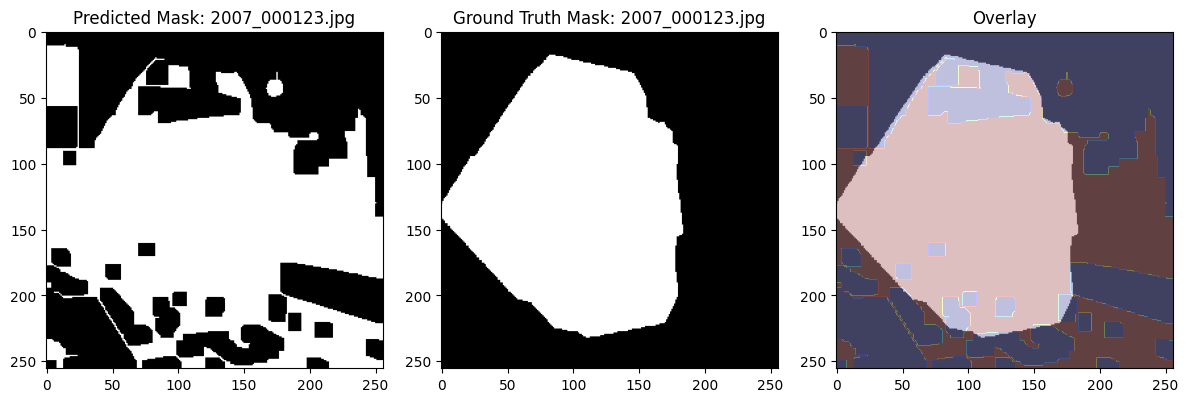

(256, 256) (256, 256)
9956475 11435730
9300615 12091590 11435730
9956475
Image: 2007_000129.jpg, IoU: 0.769180479986503, Accuracy: 0.8132943852294519, Dice: 0.869533084597871


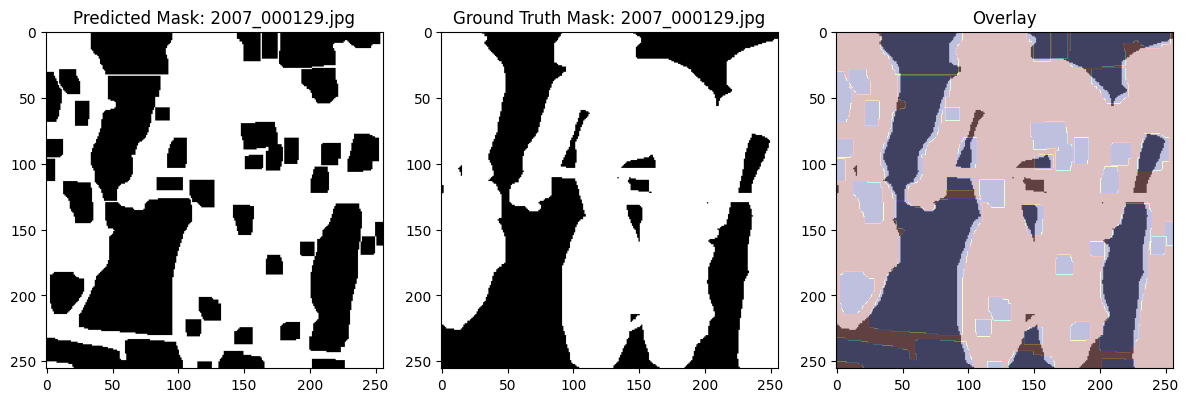

(256, 256) (256, 256)
5427165 8498895
3569235 10356825 8498895
5427165
Image: 2007_000170.jpg, IoU: 0.3446263695678936, Accuracy: 0.41996459539740166, Dice: 0.512597963817476


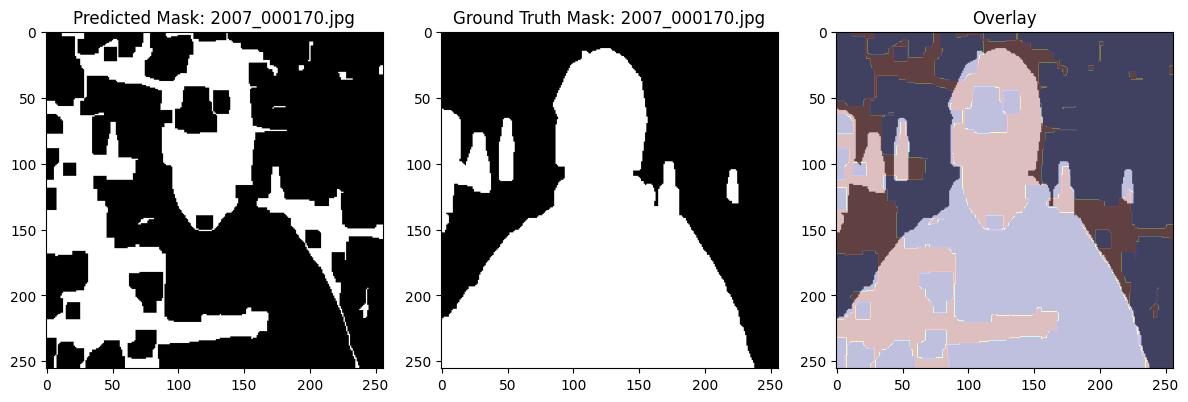

(256, 256) (256, 256)
16465860 6575430
6329610 16711680 6575430
16465860
Image: 2007_000175.jpg, IoU: 0.378753662109375, Accuracy: 0.9626153726828511, Dice: 0.5494145510082118


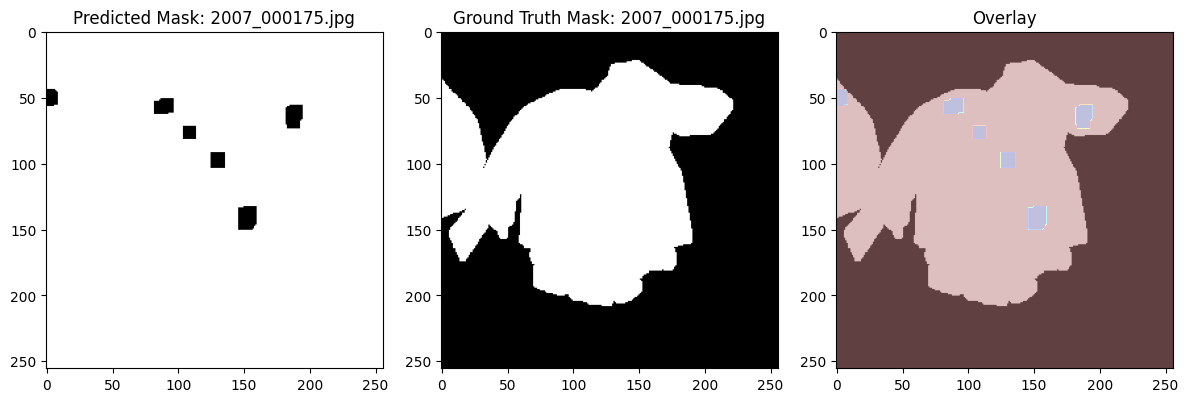

(256, 256) (256, 256)
7054830 4895235
2917200 9032865 4895235
7054830
Image: 2007_000187.jpg, IoU: 0.32295401292945264, Accuracy: 0.5959264468406522, Dice: 0.488231653970083


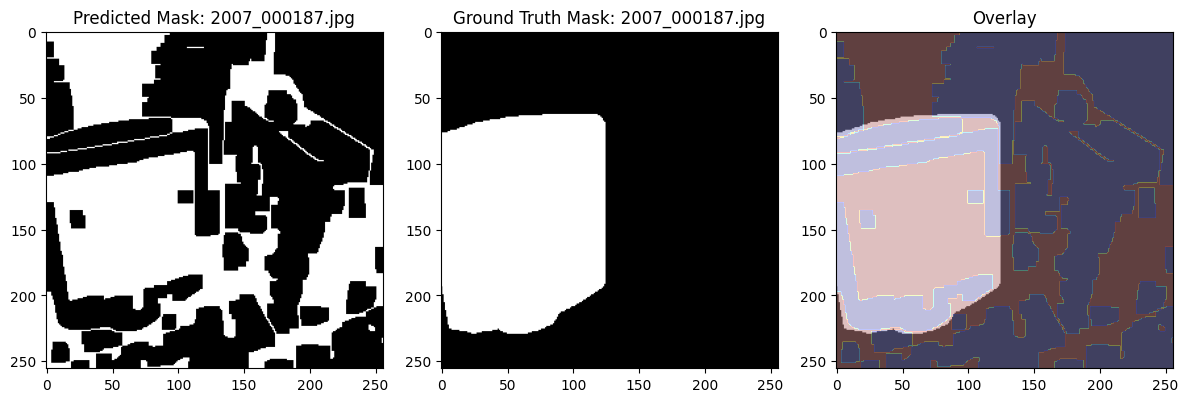

(256, 256) (256, 256)
4902120 1168155
991695 5078580 1168155
4902120
Image: 2007_000241.jpg, IoU: 0.19527013456517373, Accuracy: 0.8489412791966819, Dice: 0.3267380802352447


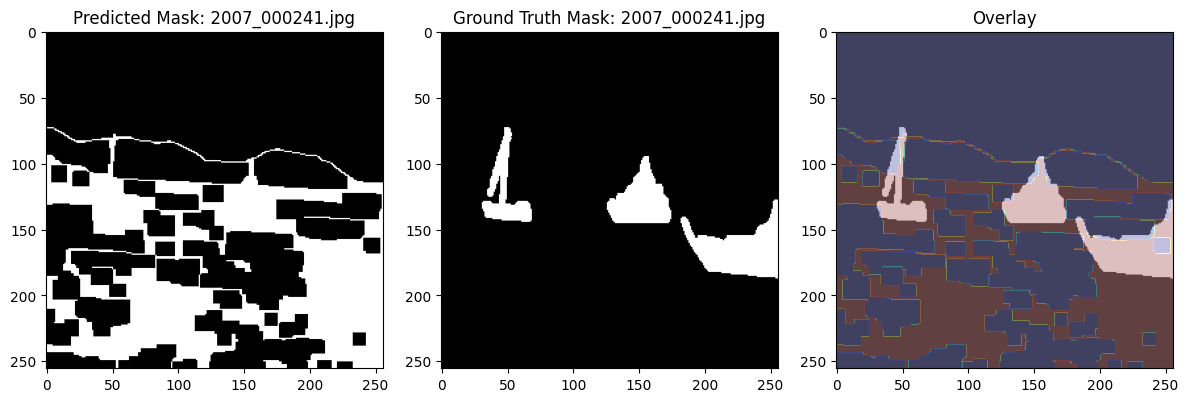

(256, 256) (256, 256)
264435 377655
259080 383010 377655
264435
Image: 2007_000243.jpg, IoU: 0.6764314247669774, Accuracy: 0.6860229574611749, Dice: 0.806989674344718


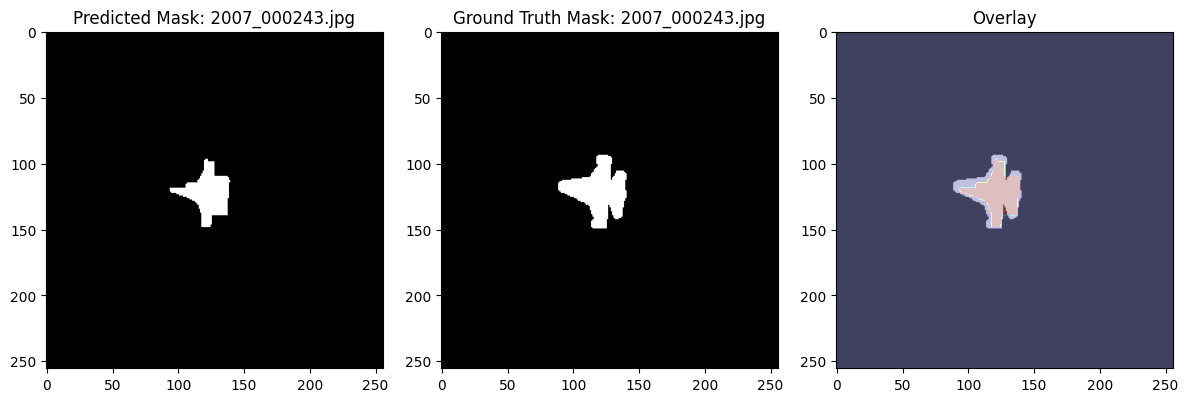

Average Metrics - IoU: 0.3435433218585167 Accuracy: 0.6785842252884358 Dice: 0.4834558072317325


In [223]:
def main(input_folder, gt_folder):
    image_files = [f for f in os.listdir(input_folder) if f.endswith(('.png', '.jpg', '.jpeg'))]

    ious = []
    accuracies = []
    dices = []

    for image_file in image_files[1:16]:  # Adjust range as needed
        image_path = os.path.join(input_folder, image_file)
        gt_path = os.path.join(gt_folder, os.path.splitext(image_file)[0] + '.png')

        image = cv2.imread(image_path)      
        predicted_mask = mask_on(image_path)  # implemented masking function

        ground_truth_mask = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)
        ground_truth_mask = cv2.resize(ground_truth_mask, (256, 256))

        # Ensure the mask is binary
        _, ground_truth_mask = cv2.threshold(ground_truth_mask, 1, 255, cv2.THRESH_BINARY)

        # print(predicted_mask.shape, ground_truth_mask.shape)
        # print(np.sum(predicted_mask), np.sum(ground_truth_mask))
        metrics = compare_masks(predicted_mask, ground_truth_mask)
        if metrics is None:
            continue
        
        ious.append(metrics['IoU'])
        accuracies.append(metrics['Accuracy'])
        dices.append(metrics['Dice'])

        # print(metrics)
        print(f"Image: {image_file}, IoU: {metrics['IoU']:}, Accuracy: {metrics['Accuracy']:}, Dice: {metrics['Dice']:}")

        visualize_comparison(image_file, predicted_mask, ground_truth_mask)

    average_iou = np.mean(ious)
    average_accuracy = np.mean(accuracies)
    average_dice = np.mean(dices)

    print("Average Metrics - IoU:", average_iou, "Accuracy:", average_accuracy, "Dice:", average_dice)

if __name__ == "__main__":
    input_folder = 'data/VOCdevkit/VOC2012/JPEGImages'      # Input images folder
    gt_folder = 'data/VOCdevkit/VOC2012/SegmentationClass'  # Ground truth masks folder
    main(input_folder, gt_folder)